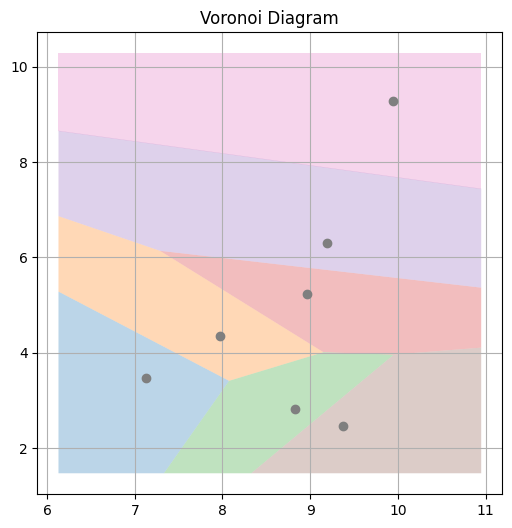

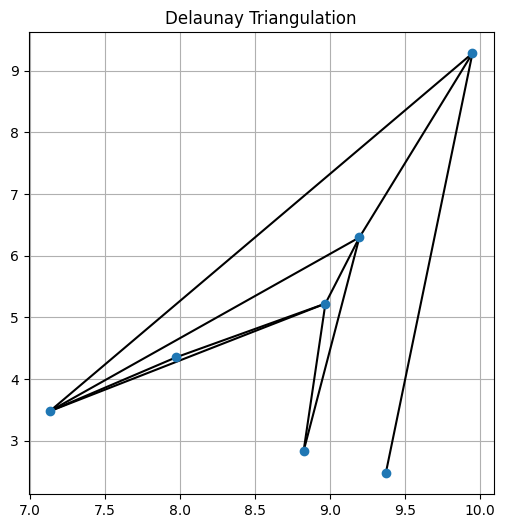

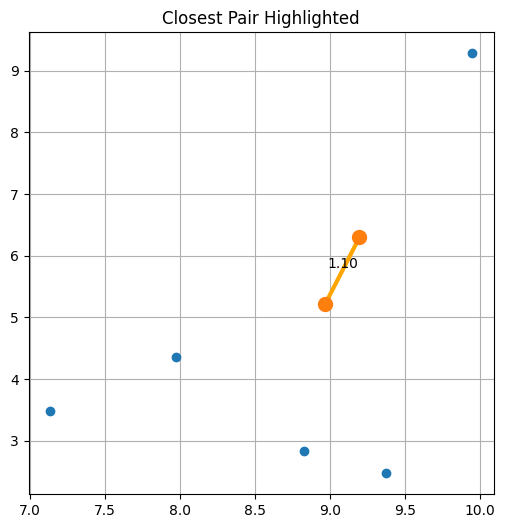

Generated 7 points. Closest pair: (1, 2), distance = 1.0974


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. функции для диаграммы вороного
def bisector(p1, p2):
    mid = (p1 + p2) / 2
    dx, dy = p2 - p1
    A, B = dx, dy
    C = A * mid[0] + B * mid[1]
    return A, B, C

def clip_polygon(polygon, A, B, C):
    new_poly = []
    n = len(polygon)
    for i in range(n):
        cur, nxt = polygon[i], polygon[(i + 1) % n]
        cur_in = (A * cur[0] + B * cur[1]) <= C
        nxt_in = (A * nxt[0] + B * nxt[1]) <= C
        if cur_in:
            new_poly.append(cur)
        if cur_in != nxt_in:
            denom = A * (nxt[0] - cur[0]) + B * (nxt[1] - cur[1])
            if abs(denom) < 1e-10:
                continue
            t = (C - (A * cur[0] + B * cur[1])) / denom
            new_poly.append(cur + t * (nxt - cur))
    return np.array(new_poly)

class VoronoiCell:
    def __init__(self, site, polygon):
        self.site = site
        self.polygon = polygon

def voronoi_divide_and_conquer(seeds, bbox):
    n = len(seeds)
    if n == 1: # для одного сайта ячейка это и многоугольник
        return [VoronoiCell(seeds[0], bbox.copy())]
    if n == 2:
        A, B, C = bisector(seeds[0], seeds[1])
        return [
            VoronoiCell(seeds[0], clip_polygon(bbox.copy(),  A,  B,  C)),
            VoronoiCell(seeds[1], clip_polygon(bbox.copy(), -A, -B, -C))
        ]
    idx = np.argsort(seeds[:,0])
    pts_sorted = seeds[idx]

    mid = n // 2
    left = voronoi_divide_and_conquer(pts_sorted[:mid], bbox)
    right = voronoi_divide_and_conquer(pts_sorted[mid:], bbox)

    cells = []
    left_sites = [c.site for c in left]
    right_sites = [c.site for c in right]

    for cell in left + right:
        poly = cell.polygon.copy()
        
        # выбираем, с кем слева или справа сравнивать
        others = right_sites if tuple(cell.site) in map(tuple, left_sites) else left_sites
        for s in others:
            A, B, C = bisector(cell.site, s)
            # убедиться, что отсечём ту сторону, где лежит наша точка:
            if (A * s[0] + B * s[1]) < (A * cell.site[0] + B * cell.site[1]):
                A, B, C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if poly.size == 0:
                break
        cells.append(VoronoiCell(cell.site, poly))
    return cells

# 2. рандомные точки
num_points = 7
scale = 10
points = np.random.rand(num_points, 2) * scale

# 3. строим окружную коробку
min_xy = points.min(axis=0) - 1
max_xy = points.max(axis=0) + 1
bbox = np.array([[min_xy[0], min_xy[1]], [min_xy[0], max_xy[1]],
                 [max_xy[0], max_xy[1]], [max_xy[0], min_xy[1]]])

# 4. считаем диаграмму вороного
cells = voronoi_divide_and_conquer(points, bbox)

# 5. достаем отрезки для делоне
edge_to_sites = defaultdict(set)
site_idx = {tuple(c.site): i for i, c in enumerate(cells)}
for cell in cells:
    poly = cell.polygon
    for k in range(len(poly)):
        edge = frozenset({
            tuple(np.round(poly[k],4)),
            tuple(np.round(poly[(k+1)%len(poly)],4))
        })
        edge_to_sites[edge].add(tuple(cell.site))

delaunay_edges = set()
for sites in edge_to_sites.values():
    if len(sites) == 2:
        i1, i2 = sorted([site_idx[s] for s in sites])
        delaunay_edges.add((i1, i2))
edges = list(delaunay_edges)

# 6. Find closest pair
min_dist, pair = float('inf'), None
for i, j in edges:
    d = np.linalg.norm(points[i] - points[j])
    if d < min_dist:
        min_dist = d
        pair = (i, j)


plt.figure(figsize=(6,6))
for c in cells:
    poly = c.polygon
    if len(poly) > 0:
        plt.fill(poly[:,0], poly[:,1], alpha=0.3)
plt.scatter(points[:,0], points[:,1], zorder=5)
plt.title("Voronoi Diagram")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], zorder=5)
for i, j in edges:
    p1, p2 = points[i], points[j]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black')
plt.title("Delaunay Triangulation")
plt.grid(True)
plt.show()

i, j = pair
p1, p2 = points[i], points[j]
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], zorder=5)
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=3, color='orange')
plt.scatter([p1[0], p2[0]], [p1[1], p2[1]], s=100, zorder=6)
mid = (p1 + p2) / 2
plt.text(mid[0], mid[1], f"{min_dist:.2f}", ha='center', va='bottom')
plt.title("Closest Pair Highlighted")
plt.grid(True)
plt.show()

print(f"Generated {num_points} points. Closest pair: {pair}, distance = {min_dist:.4f}")
